In [27]:
from __future__ import print_function, division   # Ensures Python3 printing & division standard
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.colors import LogNorm
import numpy as np
import csv
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, poisson
import pandas as pd 
from pandas import Series, DataFrame 
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import time
from sklearn.ensemble import RandomForestRegressor


In [28]:
data = pd.DataFrame(np.genfromtxt('AppML_InitialProject_train.csv', names=True, delimiter=','))
variables = data.columns

electron_classification = data["p_Truth_isElectron"]
electron_data = data[electron_classification == 1]

regression_target = electron_data["p_Truth_Energy"]

input_variables = variables[(variables != "p_Truth_isElectron") & (variables != "p_Truth_Energy")]
input_data = electron_data[input_variables]


In [29]:

# Split dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(input_data, regression_target, test_size=0.2, random_state=42)

Regression using random forest

Training time: 488.95 seconds


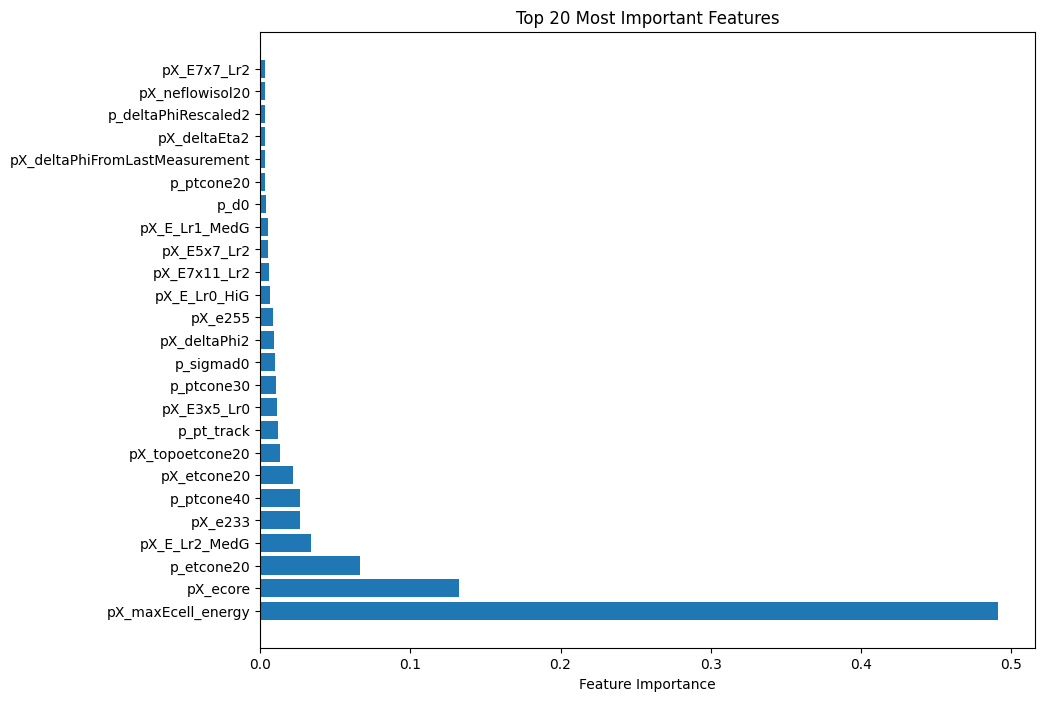

Top 25 Features: ['pX_E7x7_Lr2', 'pX_neflowisol20', 'p_deltaPhiRescaled2', 'pX_deltaEta2', 'pX_deltaPhiFromLastMeasurement', 'p_ptcone20', 'p_d0', 'pX_E_Lr1_MedG', 'pX_E5x7_Lr2', 'pX_E7x11_Lr2', 'pX_E_Lr0_HiG', 'pX_e255', 'pX_deltaPhi2', 'p_sigmad0', 'p_ptcone30', 'pX_E3x5_Lr0', 'p_pt_track', 'pX_topoetcone20', 'pX_etcone20', 'p_ptcone40', 'pX_e233', 'pX_E_Lr2_MedG', 'p_etcone20', 'pX_ecore', 'pX_maxEcell_energy']


In [30]:

# Train a RandomForestRegressor to get feature importances
rf = RandomForestRegressor(n_estimators=100, random_state=42)

start_time = time.time()
rf.fit(X_train, y_train)
end_time = time.time()

print(f"Training time: {end_time - start_time:.2f} seconds")
# Get feature importances
feature_importances = rf.feature_importances_

# Get the indices of the top 20 features
top_25_indices = np.argsort(feature_importances)[-25:]
top_25_features = [input_data.columns[i] for i in top_25_indices]

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(range(len(top_25_features)), feature_importances[top_25_indices], align='center')
plt.yticks(range(len(top_25_features)), top_25_features)
plt.xlabel('Feature Importance')
plt.title('Top 25 Most Important Features')
plt.gca().invert_yaxis()
plt.show()

print("Top 25 Features:", top_25_features)

In [31]:
# Reduce the dataset to the top 20 features
X_train_top25 = X_train.iloc[:, top_25_indices]
X_val_top25 = X_val.iloc[:, top_25_indices]

# Train a new RandomForestRegressor with the top 20 features
rf_top25 = RandomForestRegressor(n_estimators=100, random_state=42)

start_time = time.time()
rf_top25.fit(X_train_top25, y_train)
end_time = time.time()

# Make predictions and evaluate the new model
preds_top25 = rf_top25.predict(X_val_top25)

# Evaluate the model with mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_top25 = mean_absolute_percentage_error(y_val, preds_top25)
print(f"Mean Absolute Percentage Error with top 25 features: {mape_top25:.2f}%")

print(f"Training time with top 25 features: {end_time - start_time:.2f} seconds")


Mean Absolute Percentage Error with top 25 features: 30.27%
Training time with top 25 features: 91.65 seconds


In [32]:

# # Define the parameter grid
# param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }
# # Initialize and perform grid search
# rf = RandomForestRegressor(random_state=42)
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_absolute_error', verbose=2)

# # Measure the grid search time
# start_time = time.time()
# grid_search.fit(X_train_top25, y_train)
# end_time = time.time()

# grid_search_time = end_time - start_time
# print(f"Grid search time: {grid_search_time:.2f} seconds")

# # Get the best parameters from the grid search
# best_params = grid_search.best_params_
# print(f"Best hyperparameters: {best_params}")

# # Train the RandomForestRegressor with the best parameters
# rf_best = RandomForestRegressor(**best_params, random_state=42)

# # Measure the training time for the optimized model
# start_time = time.time()
# rf_best.fit(X_train_top25, y_train)
# end_time = time.time()

# training_time_rf_best = end_time - start_time
# print(f"Training time for optimized RandomForestRegressor: {training_time_rf_best:.2f} seconds")

# # Make predictions and evaluate the model
# preds_top25 = rf_best.predict(X_val_top25)
# mape_top25 = mean_absolute_percentage_error(y_val, preds_top25)
# print(f"Mean Absolute Percentage Error with top 25 features and optimized hyperparameters: {mape_top25:.2f}%")


In [33]:

param_grid = {
    'n_estimators': [200],
    'max_depth': [20],
    'min_samples_split': [2],
    'min_samples_leaf': [2]
}

# Initialize and perform grid search
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_absolute_error', verbose=2)

# Measure the grid search time
start_time = time.time()
grid_search.fit(X_train_top25, y_train)
end_time = time.time()

grid_search_time = end_time - start_time
print(f"Grid search time: {grid_search_time:.2f} seconds")

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

# Train the RandomForestRegressor with the best parameters
rf_best = RandomForestRegressor(**best_params, random_state=42)

# Measure the training time for the optimized model
start_time = time.time()
rf_best.fit(X_train_top25, y_train)
end_time = time.time()

training_time_rf_best = end_time - start_time
print(f"Training time for optimized RandomForestRegressor: {training_time_rf_best:.2f} seconds")

# Make predictions and evaluate the model
preds_top25 = rf_best.predict(X_val_top25)
mape_top25 = mean_absolute_percentage_error(y_val, preds_top25)
print(f"Mean Absolute Percentage Error with top 20 features and optimized hyperparameters: {mape_top25:.2f}%")


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 2.0min
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 2.1min
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 2.1min
Grid search time: 283.72 seconds
Best hyperparameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Training time for optimized RandomForestRegressor: 167.38 seconds
Mean Absolute Percentage Error with top 20 features and optimized hyperparameters: 30.01%


In [55]:
relative_deviation = np.abs((preds_top25 - y_val) / y_val)
mae_relative_deviation = np.mean(relative_deviation)

print(f"MAE of relative deviation on validation set: {mae_relative_deviation:.4f}")

MAE of relative deviation on validation set: 0.3001


In [34]:
mae = mean_absolute_error(y_val, preds_top25)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 7696.285606779399


In [51]:
test_data = pd.DataFrame(np.genfromtxt('AppML_InitialProject_test_regression.csv', names=True, delimiter=','))

test_input_data = test_data[input_variables]
test_input_25 = test_input_data[top_25_features]
input_data_25 = input_data[top_25_features]
print(test_input_25.columns)
start_time = time.time()
rf_best.fit(input_data_25, regression_target)
end_time = time.time()

training_time_rf_best = end_time - start_time
print(f"Training time for optimized RandomForestRegressor: {training_time_rf_best:.2f} seconds")

# Make predictions on the test data
test_preds = rf_best.predict(test_input_25)
df = pd.DataFrame(test_preds, columns=['p_Truth_Energy'])
df.to_csv('Regression_TheodoreBeevers_RandomForestRegressor.csv', index=True, header=False)

# Put variables in cv file
variables = pd.DataFrame(top_25_features, columns=['Variables'])
variables.to_csv('Regression_TheodoreBeevers_RandomForestRegressor_VariableList.csv',index=False, header=False)



Index(['pX_E7x7_Lr2', 'pX_neflowisol20', 'p_deltaPhiRescaled2', 'pX_deltaEta2',
       'pX_deltaPhiFromLastMeasurement', 'p_ptcone20', 'p_d0', 'pX_E_Lr1_MedG',
       'pX_E5x7_Lr2', 'pX_E7x11_Lr2', 'pX_E_Lr0_HiG', 'pX_e255',
       'pX_deltaPhi2', 'p_sigmad0', 'p_ptcone30', 'pX_E3x5_Lr0', 'p_pt_track',
       'pX_topoetcone20', 'pX_etcone20', 'p_ptcone40', 'pX_e233',
       'pX_E_Lr2_MedG', 'p_etcone20', 'pX_ecore', 'pX_maxEcell_energy'],
      dtype='object')
Training time for optimized RandomForestRegressor: 190.68 seconds


/opt/anaconda3/envs/appliedmachinelearning/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/140
945/945 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 32314.5781 - val_loss: 10451.9277
Epoch 2/140
945/945 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9861.1436 - val_loss: 9588.0684
Epoch 3/140
945/945 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9356.4268 - val_loss: 9121.3467
Epoch 4/140
945/945 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8935.1348 - val_loss: 8697.6943
Epoch 5/140
945/945 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8579.1436 - val_loss: 8487.9023
Epoch 6/140
945/945 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8416.1484 - val_loss: 8407.7754
Epoch 7/140
945/945 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8342.2793 - val_loss: 8242.5635
Epoch 8/140
945/945 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8333.8496 - val_loss: 8149.9810
Epoch 9/140
945/945 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8327.4521 - val_loss: 8124.8184
Epoch 10/140
945/945 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8153.3799 - val_loss: 8352.5908
Epoch 11/140
945/945 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8067.

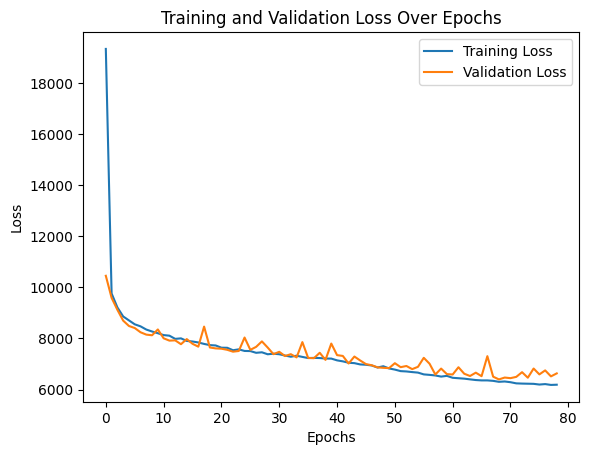

237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Mean Absolute Percentage Error: 26.04%
MAE of relative deviation on validation set: 0.2604


In [36]:
# Normalize the features using MinMaxScaler
feature_scaler = MinMaxScaler()
X_train_scaled = feature_scaler.fit_transform(X_train)
X_val_scaled = feature_scaler.transform(X_val)

# Define the model
model = keras.Sequential([
    keras.layers.Dense(40, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='mean_absolute_error')
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train_scaled, y_train, epochs=140, batch_size=32, validation_data=(X_val_scaled, y_val), callbacks=[early_stopping], verbose=1)
# Train the model

# Plot training and validation loss over epochs
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Make predictions
preds = model.predict(X_val_scaled).flatten()

# Evaluate the model with relative error
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_val, preds)
print(f"Mean Absolute Percentage Error: {mape:.2f}%")

relative_deviation_nn = np.abs((preds - y_val) / y_val)
mae_relative_deviation_nn = np.mean(relative_deviation_nn)

print(f"MAE of relative deviation on validation set: {mae_relative_deviation_nn:.4f}")



In [39]:
relative_deviation_nn = np.abs((preds - y_val) / y_val)
mae_relative_deviation_nn = np.mean(relative_deviation_nn)

print(f"MAE of relative deviation on validation set: {mae_relative_deviation_nn:.4f}")

MAE of relative deviation on validation set: 0.2604


Mean Absolute Error: 6397.92589624109


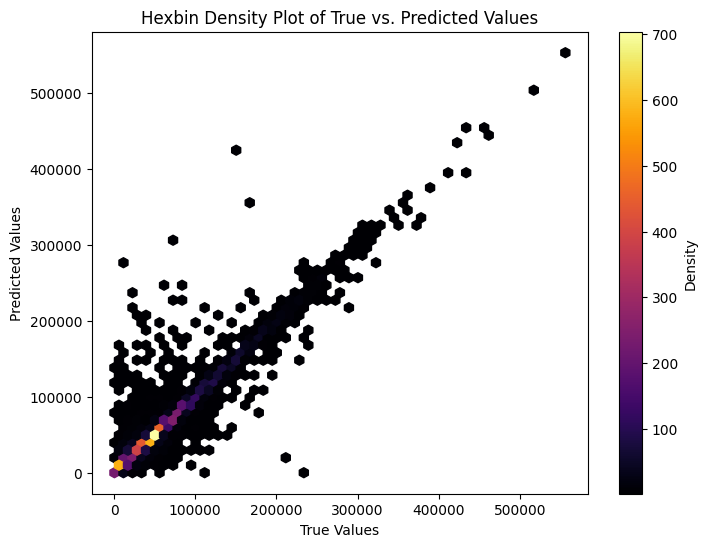

<Figure size 640x480 with 0 Axes>

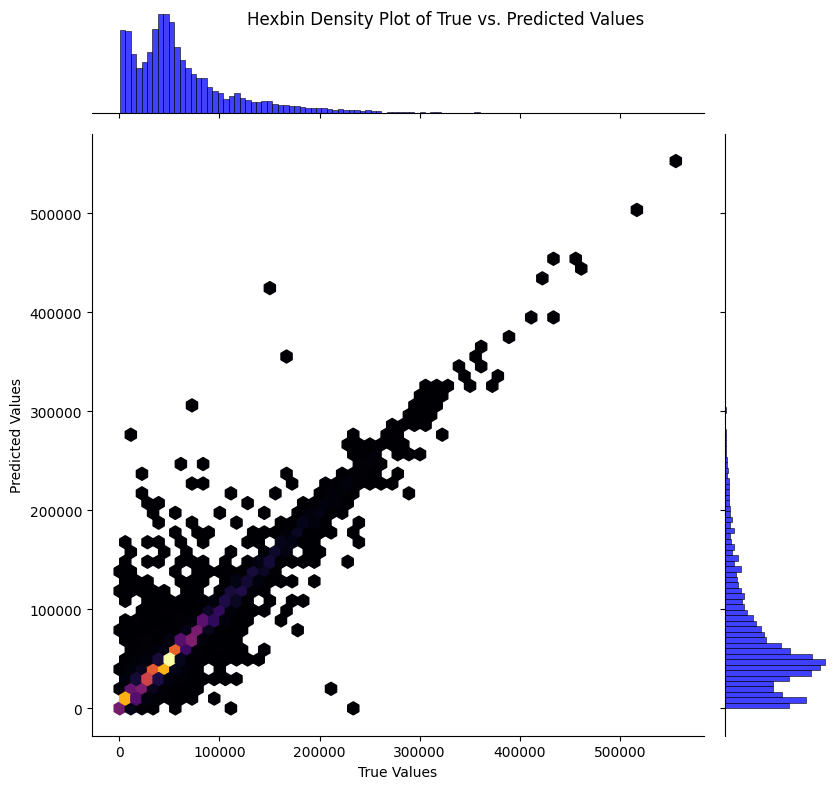

In [37]:
# Evaluate the model
mae = mean_absolute_error(y_val, preds)
print(f"Mean Absolute Error: {mae}")

plt.figure(figsize=(8, 6))
hb = plt.hexbin(y_val, preds, gridsize=50, cmap='inferno', mincnt=1)
plt.colorbar(hb, label='Density')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Hexbin Density Plot of True vs. Predicted Values')
plt.show()

import seaborn as sns

# Plot the density of points in the scatter plot using seaborn jointplot
plt.figure()
sns.jointplot(x=y_val, y=preds, kind="hex", color="blue", cmap="inferno", height=8, mincnt=1)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.suptitle('Hexbin Density Plot of True vs. Predicted Values')
plt.show()


In [ ]:
input_data_25 = input_data[top_25_features]
input_data_scaled_25 = feature_scaler.fit_transform(input_data_25)

Epoch 1/140


/opt/anaconda3/envs/appliedmachinelearning/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


945/945 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 33198.8984 - val_loss: 11042.6445
Epoch 2/140
945/945 ━━━━━━━━━━━━━━━━━━━━ 1s 960us/step - loss: 11255.4941 - val_loss: 11555.2646
Epoch 3/140
945/945 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 10979.6377 - val_loss: 10567.4033
Epoch 4/140
945/945 ━━━━━━━━━━━━━━━━━━━━ 1s 948us/step - loss: 10820.5186 - val_loss: 10482.2881
Epoch 5/140
945/945 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 10497.8867 - val_loss: 10547.6670
Epoch 6/140
945/945 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 10374.4648 - val_loss: 10249.2061
Epoch 7/140
945/945 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 10332.1855 - val_loss: 10121.6055
Epoch 8/140
945/945 ━━━━━━━━━━━━━━━━━━━━ 1s 927us/step - loss: 10367.8506 - val_loss: 10004.1152
Epoch 9/140
945/945 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 10486.2646 - val_loss: 9972.6572
Epoch 10/140
945/945 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 10230.2158 - val_loss: 9913.7363
Epoch 11/140
945/945 ━━━━━━━━━━━━━━━━━━━━ 1s 976us/step -

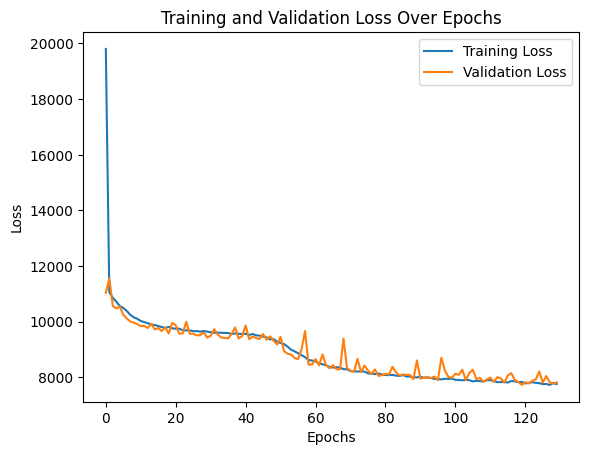

237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Mean Absolute Percentage Error: 28.89%
MAE of relative deviation on validation set (25 vars): 0.2889


In [45]:

X_train_scaled_25, X_val_scaled_25, y_train, y_val = train_test_split(input_data_scaled_25, regression_target, test_size=0.2, random_state=42)

# Define the model
model = keras.Sequential([
    keras.layers.Dense(40, activation='relu', input_shape=(X_train_scaled_25.shape[1],)),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='mean_absolute_error')
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train_scaled_25, y_train, epochs=140, batch_size=32, validation_data=(X_val_scaled_25, y_val), callbacks=[early_stopping], verbose=1)
# Train the model

# Plot training and validation loss over epochs
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Make predictions
preds = model.predict(X_val_scaled_25).flatten()

# Evaluate the model with relative error
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_val, preds)
print(f"Mean Absolute Percentage Error: {mape:.2f}%")

relative_deviation_nn = np.abs((preds - y_val) / y_val)
mae_relative_deviation_nn = np.mean(relative_deviation_nn)

print(f"MAE of relative deviation on validation set (25 vars): {mae_relative_deviation_nn:.4f}")

# Evaluate the model
mae = mean_absolute_error(y_val, preds)
print(f"Mean Absolute Error: {mae}")

plt.figure(figsize=(8, 6))
hb = plt.hexbin(y_val, preds, gridsize=50, cmap='inferno', mincnt=1)
plt.colorbar(hb, label='Density')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Hexbin Density Plot of True vs. Predicted Values')
plt.show()

import seaborn as sns

# Plot the density of points in the scatter plot using seaborn jointplot
plt.figure()
sns.jointplot(x=y_val, y=preds, kind="hex", color="blue", cmap="inferno", height=8, mincnt=1)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.suptitle('Hexbin Density Plot of True vs. Predicted Values')
plt.show()




In [56]:

model = keras.Sequential([
    keras.layers.Dense(40, activation='relu', input_shape=(input_data_scaled_25.shape[1],)),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='mean_absolute_error')

start_time = time.time()
history = model.fit(input_data_scaled_25, regression_target, epochs=130, batch_size=32, verbose=1)
end_time = time.time()

print(f"Training time: {end_time - start_time:.2f} seconds")
# Make predictions on the test data

test_input_scaled_25 = feature_scaler.transform(test_input_25)

test_preds = model.predict(test_input_scaled_25).flatten()
df = pd.DataFrame(test_preds, columns=['p_Truth_Energy'])
df.to_csv('Regression_TheodoreBeevers_NN-TensorFlow2.csv', index=True, header=False)

# Put variables in cv file
variables = pd.DataFrame(top_25_features, columns=['Variables'])
variables.to_csv('Regression_TheodoreBeevers_NN-TensorFlow2_VariableList.csv', index=False, header=False)



/opt/anaconda3/envs/appliedmachinelearning/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/130
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 32872.0586
Epoch 2/130
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 1s 893us/step - loss: 11053.3125
Epoch 3/130
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 1s 933us/step - loss: 11008.4482
Epoch 4/130
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 1s 970us/step - loss: 10675.7500
Epoch 5/130
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 10561.5801
Epoch 6/130
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 10655.8555
Epoch 7/130
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 10497.3887
Epoch 8/130
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 10411.8174
Epoch 9/130
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 10084.1094
Epoch 10/130
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9950.8633
Epoch 11/130
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9927.2939
Epoch 12/130
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 10012.4141
Epoch 13/130
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 1s 966us/step - loss: 9843.8389
Epoch 14/130
1182/1182 ━━━━━━

In [54]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_36 (Dense)                │ (None, 40)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 50)             │         2,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,835 (42.33 KB)

 Trainable params: 3,611 (14.11 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,224 (28.22 KB)

In [53]:
test_preds = model.predict(test_input_scaled_25).flatten()
df = pd.DataFrame(test_preds, columns=['p_Truth_Energy'])
df.to_csv('Regression_TheodoreBeevers_NN-TensorFlow2.csv', index=True, header=False)

# Put variables in cv file
variables = pd.DataFrame(top_25_features, columns=['Variables'])
variables.to_csv('Regression_TheodoreBeevers_NN-TensorFlow2_VariableList.csv', index=False, header=False)

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 961us/step
